# Example R Notebook

다음 실습은 R을 활용한 간단한 데이터 분석입니다. R의 기본적인 문법과 형식을 그대로 사용하면서, 대량의 데이터 처리를 위해서 Spark과 연동을 위해 SparkR을 활용합니다.
실제로 Spark의 분산처리 환경을 통해 대용량 데이터 처리가 가능합니다. 

### FLIGHTS DATA Analysis

아래 실습에서 사용하는 샘플 데이터는 nycflights13 R 패키지를 활용합니다. 이 패키지에는 2013년 뉴욕을 출발하는 336,776 편의 모든 항공편에 대한 데이터가 포함되어 있으며 항공사, 공항, 날씨 및 비행기에 대한 유용한 메타 데이터도 포함되어 있습니다. 이 데이터는 미국교통통계국(Bureau of Transportation Statistics)에서 가져온 데이터 입니다. 

#### 참고 : 다음의 install.packages 명령 구문의 최초 1회만 사용하면 됩니다. 

In [1]:
install.packages("sparklyr")
install.packages("dplyr")
install.packages("nycflights13")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


library 로딩 명령어는 세션 시작시마다 재실행이 필요합니다. 

In [2]:
library(sparklyr)
library(dplyr)
library(nycflights13)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Spark session을 얻어오는 과정입니다. 

In [3]:
sc <- spark_connect(master="local")

In [4]:
flights <- copy_to(sc, flights, "flights")
airlines <- copy_to(sc, airlines, "airlines")
#src_tbls(sc)

### 데이터 처리를 위한 패키지 : dplyr
직관적으로 데이터 처리에 매우 유용한 패키지 입니다. Spark DataFrame 형식의 데이터 변환을 위해서 dplyr 구문을 Spark SQL 형태로 바꾸어 실행됩니다. 
아래의 명령어 5개를 활용하며, 파이프라인(%>%)을 통해서 매우 쉽게 데이터 조작이 가능합니다. 

* select ~ SELECT
* filter ~ WHERE
* arrange ~ ORDER
* summarise ~ aggregators: sum, min, sd, etc.
* mutate ~ operators: +, *, log, etc.

In [5]:
select(flights, year:day, arr_delay, dep_delay)

# Source: spark<?> [?? x 5]
    year month   day arr_delay dep_delay
   <int> <int> <int>     <dbl>     <dbl>
 1  2013     1     1        11         2
 2  2013     1     1        20         4
 3  2013     1     1        33         2
 4  2013     1     1       -18        -1
 5  2013     1     1       -25        -6
 6  2013     1     1        12        -4
 7  2013     1     1        19        -5
 8  2013     1     1       -14        -3
 9  2013     1     1        -8        -3
10  2013     1     1         8        -2
# … with more rows

In [6]:
filter(flights, dep_delay > 1000)

# Source: spark<?> [?? x 19]
   year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
  <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
1  2013     1     9      641            900      1301     1242           1530
2  2013     1    10     1121           1635      1126     1239           1810
3  2013     6    15     1432           1935      1137     1607           2120
4  2013     7    22      845           1600      1005     1044           1815
5  2013     9    20     1139           1845      1014     1457           2210
# … with 11 more variables: arr_delay <dbl>, carrier <chr>, flight <int>,
#   tailnum <chr>, origin <chr>, dest <chr>, air_time <dbl>, distance <dbl>,
#   hour <dbl>, minute <dbl>, time_hour <dttm>

In [7]:
arrange(flights, desc(dep_delay))

# Source:     spark<?> [?? x 19]
# Ordered by: desc(dep_delay)
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     9      641            900      1301     1242           1530
 2  2013     6    15     1432           1935      1137     1607           2120
 3  2013     1    10     1121           1635      1126     1239           1810
 4  2013     9    20     1139           1845      1014     1457           2210
 5  2013     7    22      845           1600      1005     1044           1815
 6  2013     4    10     1100           1900       960     1342           2211
 7  2013     3    17     2321            810       911      135           1020
 8  2013     6    27      959           1900       899     1236           2226
 9  2013     7    22     2257            759       898      121           1026
10  2013    12     5      756           1700       896     1058     

In [8]:
summarise(flights, mean_dep_delay = mean(dep_delay))

Warning message:
“Missing values are always removed in SQL.
Use `AVG(x, na.rm = TRUE)` to silence this warning”Warning message:
“Missing values are always removed in SQL.
Use `AVG(x, na.rm = TRUE)` to silence this warning”Warning message:
“Missing values are always removed in SQL.
Use `AVG(x, na.rm = TRUE)` to silence this warning”Warning message:
“Missing values are always removed in SQL.
Use `AVG(x, na.rm = TRUE)` to silence this warning”Warning message:
“Missing values are always removed in SQL.
Use `AVG(x, na.rm = TRUE)` to silence this warning”

# Source: spark<?> [?? x 1]
  mean_dep_delay
           <dbl>
1           12.6

In [9]:
mutate(flights, speed = distance / air_time * 60)

# Source: spark<?> [?? x 20]
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      517            515         2      830            819
 2  2013     1     1      533            529         4      850            830
 3  2013     1     1      542            540         2      923            850
 4  2013     1     1      544            545        -1     1004           1022
 5  2013     1     1      554            600        -6      812            837
 6  2013     1     1      554            558        -4      740            728
 7  2013     1     1      555            600        -5      913            854
 8  2013     1     1      557            600        -3      709            723
 9  2013     1     1      557            600        -3      838            846
10  2013     1     1      558            600        -2      753            745
# … with more rows, and

### Laziness
데이터베이스 작업을 할때 Spark에서는 가능하면 늦게 작업을 진행하고자 합니다. dplyr도 동일한 Laziness를 가지고 있습니다. 

* 명시적으로 요청하지 않는 한 데이터를 R로 가져 오지 않습니다.

* 마지막 순간까지 모든 작업을 지연합니다. 원하는 작업을 모두 준비한 이후에 데이터베이스로 데이터를 보냅니다.

아래의 예제 코드를 참조하세요 

In [10]:
c1 <- filter(flights, day == 17, month == 5, carrier %in% c('UA', 'WN', 'AA', 'DL'))
c2 <- select(c1, year, month, day, carrier, dep_delay, air_time, distance)
c3 <- arrange(c2, year, month, day, carrier)
c4 <- mutate(c3, air_time_hours = air_time / 60)

In [11]:
c4

# Source:     spark<?> [?? x 8]
# Ordered by: year, month, day, carrier
    year month   day carrier dep_delay air_time distance air_time_hours
   <int> <int> <int> <chr>       <dbl>    <dbl>    <dbl>          <dbl>
 1  2013     5    17 AA             -7      142     1089           2.37
 2  2013     5    17 AA             -9      186     1389           3.1 
 3  2013     5    17 AA             -6      143     1096           2.38
 4  2013     5    17 AA             -7      119      733           1.98
 5  2013     5    17 AA             -4      114      733           1.9 
 6  2013     5    17 AA             -2      146     1085           2.43
 7  2013     5    17 AA             -2      185     1372           3.08
 8  2013     5    17 AA             -3      193     1598           3.22
 9  2013     5    17 AA             -7      137      944           2.28
10  2013     5    17 AA             -1      195     1389           3.25
# … with more rows

### Piping

magrittr 파이프 (%>%)를 사용하여 더 명확한 구문을 작성할 수 있습니다. 아래 예제를 참고하면 쉽게 이해를 할 수 있습니다. 

In [12]:
c4 <- flights %>%
  filter(month == 5, day == 17, carrier %in% c('UA', 'WN', 'AA', 'DL')) %>%
  select(carrier, dep_delay, air_time, distance) %>%
  arrange(carrier) %>%
  mutate(air_time_hours = air_time / 60)

### Grouping

group_by 함수는 SQL의 GROUP BY 문과 동일하게 동작합니다. 

In [13]:
c4 %>%
  group_by(carrier) %>%
  summarize(count = n(), mean_dep_delay = mean(dep_delay))

Warning message:
“Missing values are always removed in SQL.
Use `AVG(x, na.rm = TRUE)` to silence this warning”Warning message:
“Missing values are always removed in SQL.
Use `AVG(x, na.rm = TRUE)` to silence this warning”Warning message:
“Missing values are always removed in SQL.
Use `AVG(x, na.rm = TRUE)` to silence this warning”Warning message:
“Missing values are always removed in SQL.
Use `AVG(x, na.rm = TRUE)` to silence this warning”Warning message:
“Missing values are always removed in SQL.
Use `AVG(x, na.rm = TRUE)` to silence this warning”

# Source: spark<?> [?? x 3]
  carrier count mean_dep_delay
  <chr>   <dbl>          <dbl>
1 AA         94           1.47
2 DL        136           6.24
3 UA        172           9.63
4 WN         34           7.97

### Collecting to R

collect ()를 사용하여 Spark에서 R의 메모리로 데이터를 복사 할 수 있습니다.

In [14]:
carrierhours <- collect(c4)

**collect()**는 Spark 쿼리를 실행하고 결과를 R로 반환하여 추가 분석과 시각화를 수행합니다.

In [15]:
# Test the significance of pairwise differences and plot the results
with(carrierhours, pairwise.t.test(air_time, carrier))


	Pairwise comparisons using t tests with pooled SD 

data:  air_time and carrier 

   AA      DL      UA     
DL 0.25057 -       -      
UA 0.07957 0.00044 -      
WN 0.07957 0.23488 0.00041

P value adjustment method: holm 

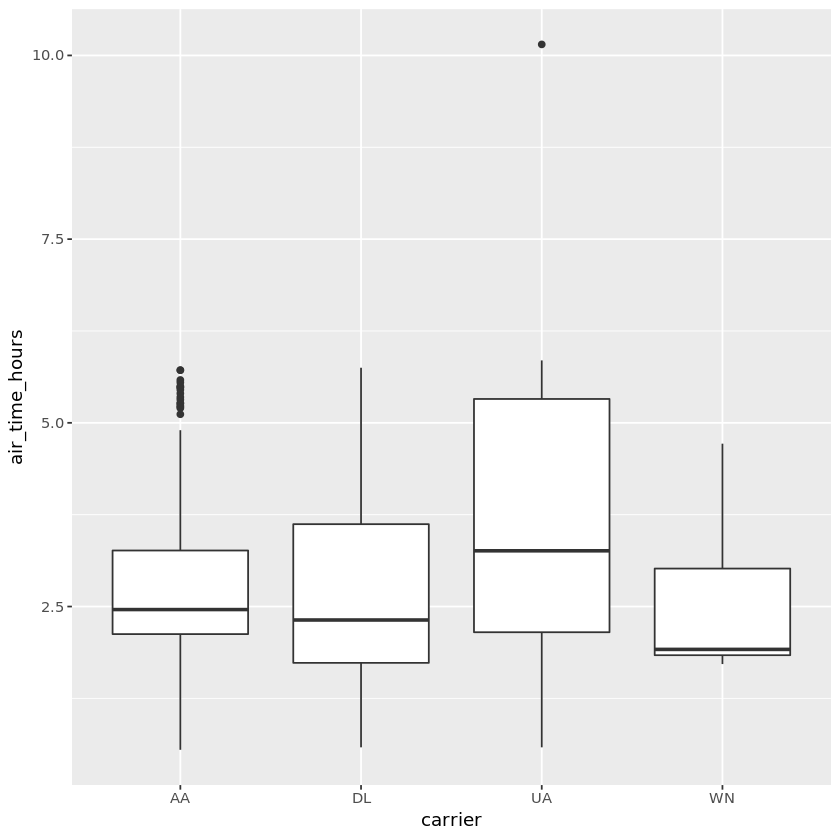

In [16]:
ggplot(carrierhours, aes(carrier, air_time_hours)) + geom_boxplot()

### Peforming Joins

데이터 분석에는 단 하나의 테이블만 사용하는 경우는 거의 없기 때문에 다수의 테이블을 결합하는 도구가 필요합니다. dplyr에는 몇가지 테이블을 조합하는 방법이 있습니다. 

* 다른 테이블에 일치하는 행에서 한 테이블에 새로운 변수를 추가하는 조인 (mutating join).

* 필터링 조인은 다른 테이블의 관찰과 일치하는지 여부에 따라 하나의 테이블에서 관찰을 필터링합니다.

* 설정 작업 : 데이터 세트의 관측 값을 설정된 요소처럼 결합합니다.


In [17]:
flights %>% left_join(airlines)

Joining, by = "carrier"


# Source: spark<?> [?? x 20]
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      517            515         2      830            819
 2  2013     1     1      533            529         4      850            830
 3  2013     1     1      542            540         2      923            850
 4  2013     1     1      544            545        -1     1004           1022
 5  2013     1     1      554            600        -6      812            837
 6  2013     1     1      554            558        -4      740            728
 7  2013     1     1      555            600        -5      913            854
 8  2013     1     1      557            600        -3      709            723
 9  2013     1     1      557            600        -3      838            846
10  2013     1     1      558            600        -2      753            745
# … with more rows, and

In [18]:
flights %>% left_join(airlines, by = c("carrier", "carrier"))

# Source: spark<?> [?? x 20]
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      517            515         2      830            819
 2  2013     1     1      533            529         4      850            830
 3  2013     1     1      542            540         2      923            850
 4  2013     1     1      544            545        -1     1004           1022
 5  2013     1     1      554            600        -6      812            837
 6  2013     1     1      554            558        -4      740            728
 7  2013     1     1      555            600        -5      913            854
 8  2013     1     1      557            600        -3      709            723
 9  2013     1     1      557            600        -3      838            846
10  2013     1     1      558            600        -2      753            745
# … with more rows, and

### Hive Functions
Hive의 내장 함수 (UDF)와 내장 된 집계 함수 (UDAF)의 대부분은 dplyr의 mutate 내부에서 호출하여 요약 할 수 있습니다.
다음 예제에서는 datediff 및 current_date Hive UDF를 사용하여 flight_date와 현재 시스템 날짜의 차이를 계산합니다.

In [19]:
flights %>% 
  mutate(flight_date = paste(year,month,day,sep="-"),
         days_since = datediff(current_date(), flight_date)) %>%
  group_by(flight_date,days_since) %>%
  tally() %>%
  arrange(-days_since)

# Source:     spark<?> [?? x 3]
# Groups:     flight_date
# Ordered by: -days_since
   flight_date days_since     n
   <chr>            <int> <dbl>
 1 2013-1-1          2366   842
 2 2013-1-2          2365   943
 3 2013-1-3          2364   914
 4 2013-1-4          2363   915
 5 2013-1-5          2362   720
 6 2013-1-6          2361   832
 7 2013-1-7          2360   933
 8 2013-1-8          2359   899
 9 2013-1-9          2358   902
10 2013-1-10         2357   932
# … with more rows